## DR Blindness detection

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# %matplotlib inline

# Fastai Library
import fastai
from fastai.vision import *
from fastai.vision.models import *
import torch

# Others
from pathlib import Path
import glob
from PIL import ImageFile

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['resnet34', 'aptos2019-blindness-detection', 'resnet50']


In [2]:
df_train = pd.read_csv("../input/aptos2019-blindness-detection/train.csv")
print(df_train.head())
print(df_train.diagnosis.unique())

        id_code  diagnosis
0  000c1434d8d7          2
1  001639a390f0          4
2  0024cdab0c1e          1
3  002c21358ce6          0
4  005b95c28852          0
[2 4 1 0 3]


In [3]:
df_train["id_code"] = df_train["id_code"] + '.png'

In [4]:
df_train.head()

,id_code,diagnosis
0,000c1434d8d7.png,2
1,001639a390f0.png,4
2,0024cdab0c1e.png,1
3,002c21358ce6.png,0
4,005b95c28852.png,0


In [5]:
data = ImageDataBunch.from_df("../input/aptos2019-blindness-detection/train_images", df_train, size= 224, bs = 32).normalize(imagenet_stats)

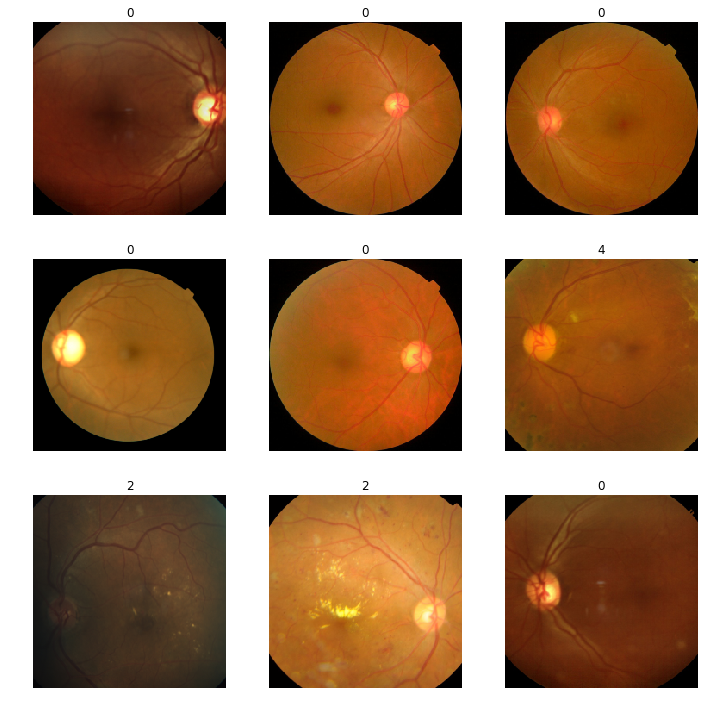

In [6]:
data.show_batch(rows=3, figsize=(10,10))

In [7]:
from os.path import join, exists, expanduser
from os import listdir, makedirs

In [8]:
cache_dir = expanduser(join('~', '.torch'))
if not exists(cache_dir):
    makedirs(cache_dir)
models_dir = join(cache_dir, 'models')
if not exists(models_dir):
    makedirs(models_dir)

In [9]:
!cp ../input/resnet50/resnet50.pth /tmp/.cache/torch/checkpoints/resnet50-19c8e357.pth

cp: cannot create regular file '/tmp/.cache/torch/checkpoints/resnet50-19c8e357.pth': No such file or directory


In [10]:
kappa = KappaScore()
kappa.weights = "quadratic"

In [ ]:
model = cnn_learner(data, resnet50, metrics = [accuracy,kappa])

In [ ]:
model.fit_one_cycle(4)

In [13]:
# first we get reference to all the fiels in the test set.
files = glob.glob('../input/aptos2019-blindness-detection/test_images/*')
total = len(files)
print('Found {} images'.format(total))

Found 1928 images


In [ ]:
# Lopping over all the file, load -> predict -> and Store the results.
# final array to hold the results.
results = []
# variable to track the progress.
i = 1

for file in files:  
    print("\rImage #{} of {} , Total Progress {}% .".format(i, total, int((i/total)*100)), end="")
    sys.stdout.flush()
    i+=1
    # open the image
    img = open_image(Path(file)).apply_tfms(None, size = 224)
    # predict
    predicted_class, idx, out = model.predict(img)
    # getting file name.
    filename = os.path.basename(file)
    results.append([filename.split(".")[0], str(predicted_class)])